# Expose NDVI calculation as a CWL Dockerized process through Examind

The goal of this tutorial / example is to demonstrate how to expose a dockerized process calculating NDVI (Normalized Difference Vegetation Index) from satellite images using CWL in Examind Community. The final objective is to be able to expose this encapsulated process as a WPS process in Examind (or OpenEO, Process API).

By Quentin BIALOTA (Geomatys)

*Based on the previous work of Guilhem LEGAL (Geomatys)*

Link of this previous work : https://github.com/Geomatys/Testbed14/tree/master/application-packages/NDVIMultiSensor

Contact : quentin.bialota@geomatys.com

## Prerequisites :

- *Only if your are using a rootless environment* | Pre-configuration of Examind => [Podman Rootless Conf](./podman_rootless.md)
- **Configure Examind (*follow it in any case*) => [Examind Conf](./examind_conf_cwl.md)**

## Setup

Setup python environment to run the commands in this notebook. (You can skip this step if you want to use postman, curl or any other HTTP client to run the HTTP requests)

In [10]:
import rasterio
import matplotlib.pyplot as plt
import requests
import json
from requests.auth import HTTPBasicAuth

SERVER_IP = "http://localhost:8080"
WPS_SERVICE_ID = "CWL_Tests"  # Name of the WPS service created in Examind
USERNAME = "admin"
PASSWORD = "admin"
auth = HTTPBasicAuth(USERNAME, PASSWORD)

## 1. Run & Configure Examind to use CWL processes

**Run examind-community with docker-compose**

Once the build is finished, you can run examind-community with docker-compose:
```bash
cd docker
docker-compose up -d
```

Once Examind is started, you can access the web interface at the URL: `http://localhost:8080/examind`

You can login with the default administrator credentials: admin/admin.

Once logged you have to create a WPS service :
- Go to **Web Services**
- Click on **Create a service**
- Select **Geoprocessing (WPS)**
- Fill the form (Name, Identifier), select version 1.0.0 AND 2.0.0
- Click on **Save**, and **Save** again
- Run the newly created WPS service by clicking on the play button (in green)

## 2. Build Docker, and deploy NDVI CWL process in Examind

**A. Build the NDVI Docker image**

You can find the Dockerfile to build the NDVI Docker image in this folder: [./Code/NDVIMultiSensor/](./Code/NDVIMultiSensor/)

To build the Docker image, run the following command in the folder containing the Dockerfile:
```bash
docker build -t images.geomatys.com/ndvims .
```

**B. Deploy the NDVI CWL process in Examind**

To check if the WPS service works, check it by running this HTTP request in your browser, with curl or postman :
- Method : GET
- URL : http://localhost:8080/examind/WS/wps/CWL_Tests/processes (CWL_Tests here is the name of the WPS service created before)

If it works, you should see a list of processes already exposed by the service.

In [2]:
URL = SERVER_IP + "/examind/WS/wps/" + WPS_SERVICE_ID + "/processes"

r = requests.get(url = URL)

data = r.json()

print("Number of processes deployed in the WPS service '" + WPS_SERVICE_ID + "' : " + str(len(data['processes'])))

Number of processes deployed in the WPS service 'CWL_Tests' : 124


Now you can deploy the NDVI CWL process in Examind, run this HTTP request :
- Method : POST
- URL : http://localhost:8080/examind/WS/wps/CWL_Tests/processes
- Body : Json format, content accessible here : [./deploy_requests_json/DeployRequest_dockerized_ndvi.json](./deploy_requests_json/DeployRequest_dockerized_ndvi.json)

*TIP: If you want to use local cwl file replace the url by a file mounted in the docker, for example :*
`"href": "file:///home/qbialota/Téléchargements/NDVIMultiSensor.cwl"`

*TIP: Sometimes the server respond with a 500 error with :*
```json
{
    "code": "NO_APPLICABLE_CODE",
    "description": "Cannot invoke \"org.constellation.dto.service.config.wps.ProcessContext.getProcesses()\" because \"context\" is null"
}
```
*But the process is actually deployed. To check if the process is deployed, run again the GET request to list the processes, or request ...*

In [3]:
postData = {
    "processDescription": {
        "process": {
            "id": "NDVIMultiSensor",
            "title": "NDVIMultiSensor",
            "owsContext": {
                "offering": {
                    "code": "http://www.opengis.net/eoc/applicationContext/cwl",
                    "content": {
                        "href": "https://raw.githubusercontent.com/Geomatys/Testbed14/master/application-packages/NDVIMultiSensor/NDVIMultiSensor.cwl"
                    }
                }
            },
            "abstract": "Normalized Difference Vegetation Index (NDVI) from an input list of satellite images.",
            "keywords": ["NDVI"],
            "inputs": [{
                "id": "files",
                "title": "Input Image",
                "minOccurs": "1",
                "maxOccurs": "unbounded",
                "input": {
                    "formats": [{
                        "mimeType": "application/zip",
                        "default": "true"
                    },
                        {
                            "mimeType": "application/x-hdf"
                        }]
                },
                "additionalParameters": [{
                    "role": "http://www.opengis.net/eoc/applicationContext/inputMetadata",
                    "parameters": [{
                        "name": "EOImage",
                        "values": ["true"]
                    }]
                }]
            }],
            "outputs": [{
                "id": "output",
                "title": "NDVI Images",
                "output": {
                    "formats": [{
                        "mimeType": "application/octet-stream",
                        "default": "true"

                    }]
                }
            }]
        },
        "processVersion": "1.0.0",
        "jobControlOptions": [
            "async-execute"
        ],
        "outputTransmission": [
            "reference"
        ]
    },
    "immediateDeployment": "true",
    "executionUnit": [{
        "href": "images.geomatys.com/ndvims:latest"
    }],
    "deploymentProfileName": "http://www.opengis.net/profiles/eoc/dockerizedApplication"
}


URL = SERVER_IP + "/examind/WS/wps/" + WPS_SERVICE_ID + "/processes"

r = requests.post(url = URL, data=json.dumps(postData), auth=auth)

data = r.json()

data

{'code': 'NO_APPLICABLE_CODE',
 'description': 'Cannot invoke "org.constellation.dto.service.config.wps.ProcessContext.getProcesses()" because "context" is null'}

**C. Test if the NDVI CWL process is deployed correctly**

To check if the NDVI CWL process is deployed correctly, run this HTTP request :
- Method : GET
- URL : http://localhost:8080/examind/WS/wps/CWL_Tests/processes/urn:exa:wps:examind-dynamic::NDVIMultiSensor

If it works, you should see the description of the NDVI CWL process, as [here](./deploy_requests_json/ProcessResult_dockerized_ndvi.json)

In [4]:
PROCESS_ID = "urn:exa:wps:examind-dynamic::NDVIMultiSensor"
URL = SERVER_IP + "/examind/WS/wps/" + WPS_SERVICE_ID + "/processes/" + PROCESS_ID

r = requests.get(url = URL)

data = r.json()

data

{'id': 'urn:exa:wps:examind-dynamic::NDVIMultiSensor',
 'title': 'NDVIMultiSensor',
 'version': '1.0.0',
 'jobControlOptions': ['sync-execute', 'async-execute', 'dismiss'],
 'outputTransmission': ['reference', 'value'],
 'inputs': [{'id': 'urn:exa:wps:examind-dynamic::NDVIMultiSensor:input:files',
   'title': 'Input Image',
   'description': 'No description available',
   'minOccurs': '1',
   'maxOccurs': 'unbounded',
   'additionalParameters': [{'role': 'http://www.opengis.net/eoc/applicationContext/inputMetadata',
     'parameters': [{'name': 'EOImage', 'values': ['true']}]}],
   'input': {'formats': [{'mimeType': 'application/zip',
      'maximumMegabytes': 100,
      'default': True},
     {'mimeType': 'application/x-hdf',
      'maximumMegabytes': 100,
      'default': False}]}}],
 'outputs': [{'id': 'urn:exa:wps:examind-dynamic::NDVIMultiSensor:output:output',
   'title': 'NDVI Images',
   'output': {'formats': [{'mimeType': 'application/octet-stream',
      'default': True}]},
 

## 5. Execute the NDVI CWL process in Examind

**A. Execution**

You can execute the NDVI CWL process by running this HTTP request :
- Method : POST
- URL : http://localhost:8080/examind/WS/wps/CWL_Tests/processes/urn:exa:wps:examind-dynamic::NDVIMultiSensor/jobs
- Body : Json format, content accessible here : [./execute_requests_json/ExecuteRequest_dockerized_ndvi.json](./execute_requests_json/ExecuteRequest_dockerized_ndvi.json)

*TIP: You can replace the input files by some on your computer, it will be faster than downloading from the internet. Just replace the href by the correct path.*

*Here are the files I used for this test :*
- [PROBAV_L1C_20160101_004905_2_V101.HDF5](https://nexus.geomatys.com/repository/raw-public/testbed14/PROBAV_L1C_20160101_004905_2_V101.HDF5)
- [S2A_MSIL1C_20180610T154901_N0206_R054_T18TXR_20180610T193029.SAFE.zip](https://nexus.geomatys.com/repository/raw-public/testbed14/S2A_MSIL1C_20180610T154901_N0206_R054_T18TXR_20180610T193029.SAFE.zip)

If you want to use local file instead of url :
- Add `"scheme": "file"` in the `format` nodes of your json request
```json
"id": "urn:exa:wps:examind-dynamic::NDVIMultiSensor:input:files",
"input": {
    "format": {
        "mimeType": "application/x-hdf",
        "scheme": "file"
    },
    "value": {
        "href": "/home/qbialota/Téléchargements/PROBAV_L1C_20160101_004905_2_V101.HDF5"
    }
}
```
- Put your file in a volume accessible by docker (inside the docker container)
*Here I created a mount point between my Download folder, and a Download folder inside docker*
```
- "/home/qbialota/Téléchargements/:/home/qbialota/Téléchargements/:Z"

In [6]:
postData = {
    "inputs": [
        {
            "id": "urn:exa:wps:examind-dynamic::NDVIMultiSensor:input:files",
            "input": {
                "format": {
                    "mimeType": "application/x-hdf"
                },
                "value": {
                    "href": "https://nexus.geomatys.com/repository/raw-public/testbed14/PROBAV_L1C_20160101_004905_2_V101.HDF5"
                }
            }

        },
        {
            "id": "urn:exa:wps:examind-dynamic::NDVIMultiSensor:input:files",
            "input": {
                "format": {
                    "mimeType": "application/zip"
                },
                "value": {
                    "href": "https://nexus.geomatys.com/repository/raw-public/testbed14/S2A_MSIL1C_20180610T154901_N0206_R054_T18TXR_20180610T193029.SAFE.zip"
                }
            }
        }
    ],
    "outputs": [
        {
            "id": "urn:exa:wps:examind-dynamic::NDVIMultiSensor:output:output",
            "transmissionMode": "reference"
        }
    ]
}


PROCESS_ID = "urn:exa:wps:examind-dynamic::NDVIMultiSensor"
URL = SERVER_IP + "/examind/WS/wps/" + WPS_SERVICE_ID + "/processes/" + PROCESS_ID + "/jobs"

r = requests.post(url = URL, data=json.dumps(postData), auth=auth)

data = r.json()

data

{'outputs': [{'id': 'urn:exa:wps:examind-dynamic::NDVIMultiSensor:output:output',
   'value': {'href': 'http://localhost:8080/examind/WS/wps/CWL_Tests/products/42a9d196-bad8-4672-b11b-0f607cb5ece2-results/82cc5c19-ee39-4051-8e02-6e70c4d21f3f.tif'}},
  {'id': 'urn:exa:wps:examind-dynamic::NDVIMultiSensor:output:output',
   'value': {'href': 'http://localhost:8080/examind/WS/wps/CWL_Tests/products/42a9d196-bad8-4672-b11b-0f607cb5ece2-results/c1bf91df-cd3a-4979-88e2-74652142fc1a.tif'}}]}

You receive in result a list of links of downloable content (here tiffs from the NDVI process).

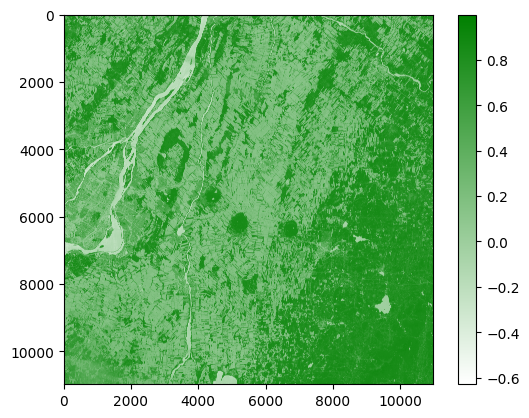

In [15]:
# Download the date first, then you can edit this code to put your Download folder
with rasterio.open("./execute_requests_json/82cc5c19-ee39-4051-8e02-6e70c4d21f3f.tif") as src:
    image_data = src.read()

cmap = plt.cm.colors.LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
plt.imshow(image_data.transpose([1, 2, 0]), cmap=cmap)
plt.colorbar()
plt.show()

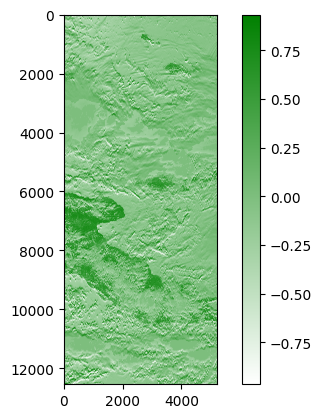

In [12]:
# Download the date first, then you can edit this code to put your Download folder
with rasterio.open("./execute_requests_json/82cc5c19-ee39-4051-8e02-6e70c4d21f3f.tif") as src:
    image_data = src.read()

cmap = plt.cm.colors.LinearSegmentedColormap.from_list('white_to_green', ['white', 'green'])
plt.imshow(image_data.transpose([1, 2, 0]), cmap=cmap)
plt.colorbar()
plt.show()